In [40]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [2]:
# define a simple MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

In [3]:
def random_points_in_annulus(r_inner: float, r_outer: float, n: int) -> torch.Tensor:
    """
    Generate random points in a specified annulus.

    Args:
        r_inner: the inner radius of the annulus
        r_outer: the outer radius of the annulus
        n: the number of points to generate

    Returns:
        torch.Tensor: the points
    """
    r = torch.sqrt(torch.rand(n)) * (r_outer - r_inner) + r_inner
    theta = torch.rand(n) * 2 * np.pi
    x = r * torch.cos(theta)
    y = r * torch.sin(theta)
    return torch.stack((x, y), dim=1)

In [6]:
n = 100
positive = random_points_in_annulus(0, 1, n)
negative = random_points_in_annulus(3, 4, n)

def plot_points(positive, negative, show=True):
    plt.scatter(positive[:, 0], positive[:, 1], c='b', marker='+')
    plt.scatter(negative[:, 0], negative[:, 1], c='r', marker='*')
    if show:
        plt.show()

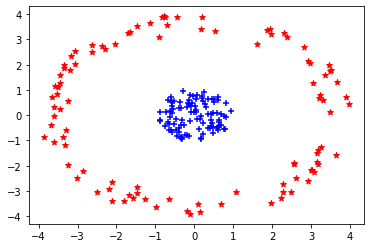

In [7]:
plot_points(positive, negative)

Epoch 100/1000 - Loss: 0.5787538290023804
Epoch 200/1000 - Loss: 0.4780276417732239
Epoch 300/1000 - Loss: 0.40149325132369995
Epoch 400/1000 - Loss: 0.327696830034256
Epoch 500/1000 - Loss: 0.25633373856544495
Epoch 600/1000 - Loss: 0.196489617228508
Epoch 700/1000 - Loss: 0.1509133279323578
Epoch 800/1000 - Loss: 0.11685017496347427
Epoch 900/1000 - Loss: 0.09163936227560043
Epoch 1000/1000 - Loss: 0.0728396475315094


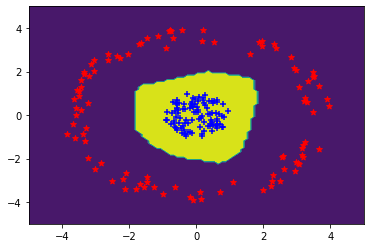

In [8]:
# train an MLP on the points
model = MLP(2, 10, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

def train(model, criterion, optimizer, positive, negative, batch_size=256, n_epochs=100):
    n = len(positive)
    k = len(negative)
    model = model.cuda()
    for epoch in range(1, n_epochs+1):
        # shuffle positve and negative
        indices = torch.randperm(n)
        positive = positive[indices]
        
        indices = torch.randperm(k)
        negative = negative[indices]

        # generate batches
        positive_batches = positive.split(batch_size)
        negative_batches = negative.split(batch_size)

        # train on each batch
        for positive_batch, negative_batch in zip(positive_batches, negative_batches):
            # create batch
            batch = torch.cat((positive_batch, negative_batch)).cuda()
            # generate labels
            labels = torch.cat((torch.ones(len(positive_batch)), torch.zeros(len(negative_batch)))).cuda()

            # forward pass
            outputs = model(batch)[:, 0]
            loss = criterion(outputs, labels)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # print loss
        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{n_epochs} - Loss: {loss.item()}')

train(model, criterion, optimizer, positive, negative, n_epochs=1000)

model = model.cpu()
# plot the points and the boundary
x = torch.linspace(-5, 5, 100)
y = torch.linspace(-5, 5, 100)
X, Y = torch.meshgrid(x, y)
Z = torch.cat((X.reshape(-1, 1), Y.reshape(-1, 1)), dim=1)
Z = torch.sign((model(Z))).reshape(100, 100).detach()
plt.contourf(X, Y, Z)

plot_points(positive, negative, show=False)

plt.show()

In [9]:
# make some test data
n_test = 30
test_data = random_points_in_annulus(0, 4, n_test)

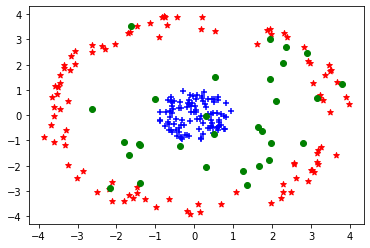

In [10]:
# test points in green
plot_points(positive, negative, show=False)
plt.scatter(test_data[:, 0], test_data[:, 1], c='g', marker='o')

In [11]:
# label the test points with model
test_labels = torch.sign(model(test_data))[:, 0]

In [12]:
# new dataset with original data plus the test data with flipped labels
new_positive = torch.cat([positive for _ in range(n_test + 1)] + [test_data[test_labels == -1]])
new_negative = torch.cat([negative for _ in range(n_test + 1)] + [test_data[test_labels == 1]])

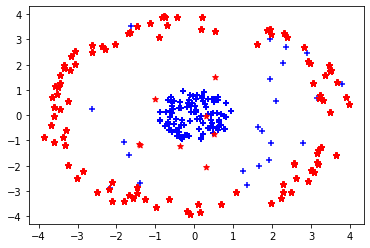

In [13]:
# plot labeled points
plot_points(new_positive, new_negative)

Epoch 100/3000 - Loss: 0.01545749418437481
Epoch 200/3000 - Loss: 0.008053483441472054
Epoch 300/3000 - Loss: 0.008259936235845089
Epoch 400/3000 - Loss: 0.013984930701553822
Epoch 500/3000 - Loss: 0.015631884336471558
Epoch 600/3000 - Loss: 0.01507811713963747
Epoch 700/3000 - Loss: 0.013798348605632782
Epoch 800/3000 - Loss: 0.008691797032952309
Epoch 900/3000 - Loss: 0.01642563007771969
Epoch 1000/3000 - Loss: 0.007392615545541048
Epoch 1100/3000 - Loss: 0.026344023644924164
Epoch 1200/3000 - Loss: 0.014967594295740128
Epoch 1300/3000 - Loss: 0.013722474686801434
Epoch 1400/3000 - Loss: 0.013419410213828087
Epoch 1500/3000 - Loss: 0.022487185895442963
Epoch 1600/3000 - Loss: 0.015300091356039047
Epoch 1700/3000 - Loss: 0.02088184654712677
Epoch 1800/3000 - Loss: 0.030069967731833458
Epoch 1900/3000 - Loss: 0.021438241004943848
Epoch 2000/3000 - Loss: 0.01781344600021839
Epoch 2100/3000 - Loss: 0.008004993200302124
Epoch 2200/3000 - Loss: 0.017234012484550476
Epoch 2300/3000 - Loss: 

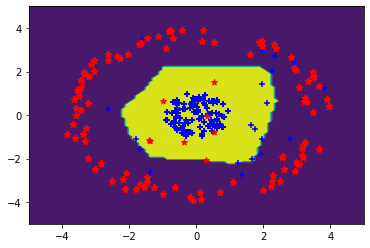

In [21]:
# train an MLP on the points
c = MLP(2, 20, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(c.parameters(), lr=1e-3, momentum=0.9)

train(c, criterion, optimizer, new_positive, new_negative, batch_size=128*64, n_epochs=3000)

# plot the points and the boundary
c = c.cpu()
x = torch.linspace(-5, 5, 100)
y = torch.linspace(-5, 5, 100)
X, Y = torch.meshgrid(x, y)
Z = torch.cat((X.reshape(-1, 1), Y.reshape(-1, 1)), dim=1)
Z = torch.sign((c(Z))).reshape(100, 100).detach()
plt.contourf(X, Y, Z)

plot_points(new_positive, new_negative, show=False)

plt.show()

In [28]:
from torch.utils.data import DataLoader

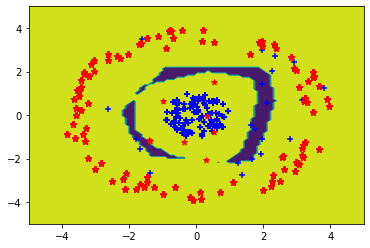

In [22]:
# view the agreement between model and c 
x = torch.linspace(-5, 5, 100)
y = torch.linspace(-5, 5, 100)
X, Y = torch.meshgrid(x, y)
Z = torch.cat((X.reshape(-1, 1), Y.reshape(-1, 1)), dim=1)
Z = (torch.sign((c(Z))) == torch.sign((model(Z)))).reshape(100, 100).detach()
plt.contourf(X, Y, Z)

plot_points(new_positive, new_negative, show=False)

plt.show()

In [44]:
with torch.no_grad():
    c_labels = torch.sign(c(test_data)).flatten()
    
accept_mask = (c_labels == test_labels)
test_data = test_data[accept_mask]
test_labels = test_labels[accept_mask]
    
# new dataset with original data plus the test data with flipped labels
n_test = len(test_data)

new_positive = torch.cat([positive for _ in range(n_test + 1)] + [test_data[test_labels == -1]])
new_negative = torch.cat([negative for _ in range(n_test + 1)] + [test_data[test_labels == 1]])

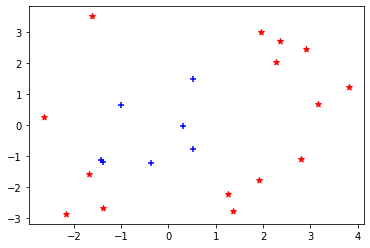

In [50]:
plot_points(test_data[test_labels==1], test_data[test_labels==-1], show=True)

In [51]:
# new dataset with original data plus the test data with flipped labels
n_test = len(test_data)

new_positive = torch.cat([positive for _ in range(n_test + 1)] + [test_data[test_labels == -1]])
new_negative = torch.cat([negative for _ in range(n_test + 1)] + [test_data[test_labels == 1]])

In [54]:
# train an MLP on the points
c2 = MLP(2, 20, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(c2.parameters(), lr=1e-3, momentum=0.9)

train(c2, criterion, optimizer, new_positive, new_negative, batch_size=128*64, n_epochs=3000)

# plot the points and the boundary
c2 = c2.cpu()
x = torch.linspace(-5, 5, 100)
y = torch.linspace(-5, 5, 100)
X, Y = torch.meshgrid(x, y)
Z = torch.cat((X.reshape(-1, 1), Y.reshape(-1, 1)), dim=1)
Z = torch.sign((c(Z))).reshape(100, 100).detach()
plt.contourf(X, Y, Z)

plot_points(new_positive, new_negative, show=False)

plt.show()

Epoch 100/3000 - Loss: 0.539137601852417
Epoch 200/3000 - Loss: 0.4734325110912323


KeyboardInterrupt: 